In [23]:
import numpy as np
import pandas as pd
import os
import math
import pickle

import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import GenericUnivariateSelect, RFECV, chi2
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn import metrics
from scipy.stats import randint
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import VotingClassifier

from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC


from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
)

from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from keras import backend as K

In [3]:
current_directory = os.getcwd()
review_training_df = pd.read_json(os.path.join(current_directory, 'training_preprocessed_scaled.json'))

In [53]:
features = review_training_df.columns.to_list()
features.remove('asin')
features.remove('awesomeness')
features.remove('joinedReviews')
features.remove('joinedSummary')

X = review_training_df[['rev_Sentiment', 'verified']]
Y = review_training_df['awesomeness']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1)

In [48]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [54]:
basic_model = Sequential()

# Adding layers to the model
# First layers: 16 neurons/perceptrons that takes the input and uses 'sigmoid' activation function.
basic_model.add(Dense(units = 16 , activation = 'sigmoid', input_shape = (2,))) 
# Second layer: 1 neuron/perceptron that takes the input from the 1st layers and gives output as 0 or 1.Activation used is 'Hard Sigmoid'
basic_model.add(Dense(1, activation = 'hard_sigmoid'))

In [55]:
# compiling the model
sgd = SGD(lr=0.01)
basic_model.compile(loss = 'binary_crossentropy', optimizer = 'sgd', metrics = [get_f1, 'accuracy'])
basic_model.fit(X_train, Y_train, epochs=10)


Epoch 1/10


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/optimizers/legacy/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1599/1599 [==============================] - 2s 1ms/step - loss: 0.6955 - get_f1: 0.6895 - accuracy: 0.5314
Epoch 2/10
1599/1599 [==============================] - 2s 1ms/step - loss: 0.6934 - get_f1: 0.6895 - accuracy: 0.5314
Epoch 3/10
1599/1599 [==============================] - 1s 925us/step - loss: 0.6929 - get_f1: 0.6897 - accuracy: 0.5314
Epoch 4/10
1599/1599 [==============================] - 2s 952us/step - loss: 0.6925 - get_f1: 0.6895 - accuracy: 0.5314
Epoch 5/10
1599/1599 [==============================] - 1s 891us/step - loss: 0.6921 - get_f1: 0.6897 - accuracy: 0.5314
Epoch 6/10
1599/1599 [==============================] - 2s 990us/step - loss: 0.6919 - get_f1: 0.6895 - accuracy: 0.5314
Epoch 7/10
1599/1599 [==============================] - 1s 913us/step - loss: 0.6916 - get_f1: 0.6895 - accuracy: 0.5314
Epoch 8/10
1599/1599 [==============================] - 1s 898us/step - loss: 0.6913 - get_f1: 0.6896 - accuracy: 0.5314
Epoch 9/10
1599/1599 [=========================

In [44]:
model_pred = (basic_model.predict(X_test) > 0.5).astype("int32")

686/686 [==============================] - 1s 666us/step


              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10234
           1       0.53      1.00      0.70     11691

    accuracy                           0.53     21925
   macro avg       0.27      0.50      0.35     21925
weighted avg       0.28      0.53      0.37     21925



/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

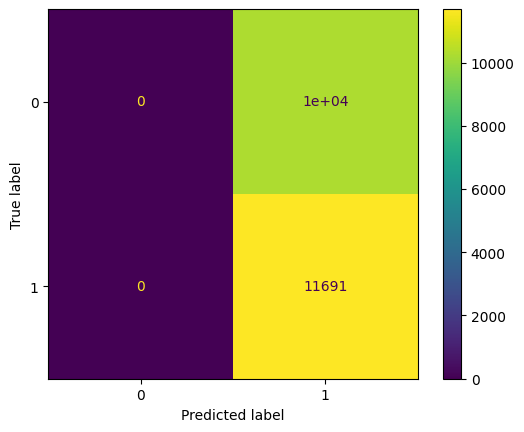

In [45]:
labels = ["0", "1"]
cm = confusion_matrix(Y_test, model_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()
print(classification_report(Y_test, model_pred))

In [33]:
model_pred

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [1]], dtype=int32)

In [60]:
test1 = pd.read_json("/Users/IanShi/Downloads/CDs_and_Vinyl_test1_labels.json")
test2 = pd.read_json("/Users/IanShi/Downloads/CDs_and_Vinyl_test2_labels.json")

In [63]:
test1

,asin,awesomeness
0,000093D54374AFE4B358EA5FBCB5776E,1
1,0000B049F5B33CD310EB1AB236E20191,1
2,000577BC760B4C7BD980939F0CB41F65,0
3,006200BEA7FE89A51080FE699DBE479B,1
4,04500D72BF81F8D5B00805B8E2E0E064,1
...,...,...
59921,2A037AF5BA7F5E3CBB5527F81B2E0FBD,1
59922,2A049F6BDE2F1538C7AA88FF38C6C24B,0
59923,2A07E088AB3E00F5C097C54326D84C37,0
59924,2A0BA71EB9D661168A8CC2310FB1F82D,1


In [64]:
test2

,asin,awesomeness
0,0000B049F5B33CD310EB1AB236E20191,1
1,00018184A9EC4D270219A296B2580303,0
2,000A550D7684BF23E1E6ABAEDC6AF618,1
3,007F749FFD59F60FECF162D41F2ED5BC,1
4,05145CC9D1558BE45CECDBA7464441D9,0
...,...,...
51522,310C774B5AD7E4CC8611AE1AA83E9B18,0
51523,31117331599F89E8D92591881C2B6A85,1
51524,3111C9228A1836E8F470A59603DE0EAC,0
51525,3119C010501FA34A2DA95C0497EBD65C,1


In [61]:
print(test1.sum())
print(test2.sum())


asin           000093D54374AFE4B358EA5FBCB5776E0000B049F5B33C...
awesomeness                                                31803
dtype: object
asin           0000B049F5B33CD310EB1AB236E2019100018184A9EC4D...
awesomeness                                                27326
dtype: object
